# Project Stage III: Calvin Ng

## Functions

I have defined functions below for use throughout this notebook. Some of these functions have been reused from previous parts, but they have been written by me.

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, skew, kurtosis
import numpy as np

In [24]:
def cumulate_weekly_data_columns(df, start_index, end_index):
    '''
    Given a start and end column, this function sums up
    each column in between and then groups days by week.
    This function is used to read data from the df set
    containing data from the US.
    
    :param df: the dataframe from which data is read from.
    :param start_index: The starting columnn.
    :param end_index: The ending column.
    :return: Two lists; one containing weeks and the other
    containing the summation of the columns of that week.
    '''
    # calculate summation of previous week
    prev_sum = 0
    prev_day = df.iloc[:, start_index - 8].sum()
    for i in range(start_index - 7, start_index):
        col = df.iloc[:, i]
        curr_day = col.sum()
        prev_sum += curr_day - prev_day
        prev_day = curr_day

    curr_sum = 0
    days_passed = 0
    weekly_x = []
    weekly_y = []
    
    # cumulate weekly data
    for i in range(start_index, end_index + 1):
        col = df.iloc[:, i]
        curr_day = col.sum()
        curr_sum += curr_day - prev_day
        prev_day = curr_day
        days_passed += 1
        if days_passed == 7:
            weekly_y.append(curr_sum)
            curr_sum = 0
            days_passed = 0
            begin_week = df.columns[i - 6]
            weekly_x.append(begin_week[-5:])
    
    return weekly_x, weekly_y

In [25]:
def normalize(dataset, population, normalization_factor):
    '''
    This function normalizes a set of values given a
    populationa nd normalization factor.
    
    :param dataset: An iterable structure containing the
    data we want to normalize.
    :param population: The population the data is describing.
    It is an integer.
    :param normalization_factor: An integer defining the
    noramlization factor; per 10,000, per 100,000, etc.
    '''
    normalized_data = []
    
    # avoid division by zero
    if population == 0:
        population = 1

    for data in dataset:
        normalized_data.append(data / population * normalization_factor)
        
    return normalized_data

In [26]:
def print_kde_stats(kde):
    '''
    This function calculates and prints statistics
    for a given KDE.
    
    :param kde: The distribution that the
    function calculates and prints statistics for.
    '''
    
    stats = {}
    
    stats['mean'] = kde.dataset.mean()
    stats['standard deviation'] = kde.dataset.std()
    stats['skewedness'] = skew(kde.dataset.flatten())
    stats['kurtosis'] = kurtosis(kde.dataset.flatten())
    
    print('Statistics per 100,000 People:')
    for key, value in stats.items():
         print('%-25s%15.2f' % (key, value))

## Section I: State New Cases Distributions

### A. Section Overview

The goal of this section is to plot the distribution graphically and then calculate key statistics about the distribution. 

To begin with, I'll reuse the code from part II to recalculate the data (weekly new cases) for the distribution. Before picking a distribution to model the data, I'll plot the data with a simple histogram to gain visual insight into the data to help me pick a type of distribution and method for estimating that distribution.

Once a distribution and method has been chosen, I can create a distribution estimator of that type with the data and calculate statistics.

In [27]:
# read base df
base = pd.read_csv('../Data/base_set_joined.csv')

In [28]:
# drop non-NC rows
nc_df = base.drop(base[base['State'] != 'NC'].index)

# get NC population
nc_population = nc_df['population'].sum()

# get start and end indices
start_index = nc_df.columns.get_loc("cases 2022-06-01")
end_index = nc_df.columns.get_loc("cases 2022-12-31")

# calculate new cases
_, nc_cases_y = cumulate_weekly_data_columns(nc_df, start_index, end_index)
nc_normalized = normalize(nc_cases_y, nc_population, 100000)

Text(0, 0.5, 'Probility Density')

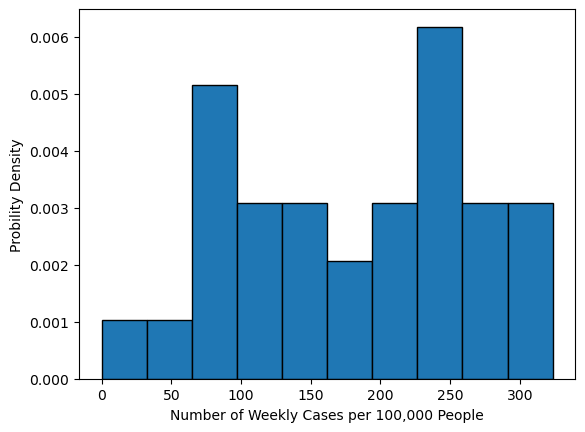

In [29]:
# plot data in a histogram
plt.hist(nc_normalized, 10, density = True, ec = 'black')
plt.xlabel('Number of Weekly Cases per 100,000 People')
plt.ylabel('Probility Density')

### B. Preliminary Histogram Analysis

Adjusting the bins of the distribution changes the nature of the histogram, but the number I settled on is ten. Depending on the number of bins, the distribution may or may not have one or two peaks.

The data appears to be skewed left. This is backed up by the basic statistics calculated in the previous stage of the project; the mean was less than the median. While the data is not significantly skewed, it is noticeable, so it would make sense to stay away from modeling the data with a normal distribution since we cannot model skewed behavior with it. 

I thought about what distribution might work best for estimating with method of moments, but ultimately, I decided none of them were adequate for my purposes. So, I switched gears and decided to instead estimate the distribution with the Kernel Density Estimators method. The reason is that the nature of the actual distribution is arbitary with this method; I don't have to know exactly what type of distribution the data follows in order to use this method.

Statistics per 100,000 People:
mean                              181.76
standard deviation                 84.57
skewedness                         -0.21
kurtosis                           -0.92


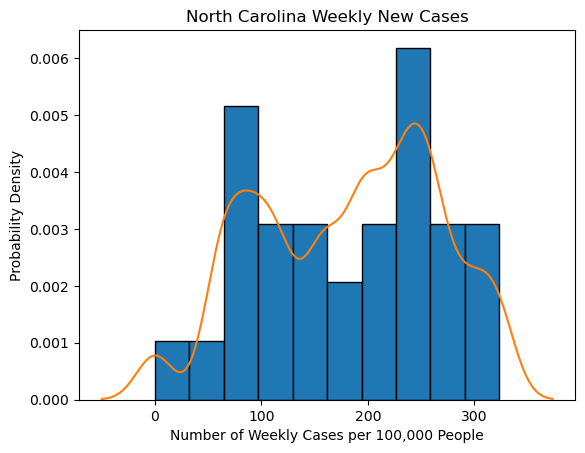

In [30]:
# create kde estimator
kde_nc = gaussian_kde(nc_normalized, bw_method = 0.2)

# evaluate pdf over kde domain
x_min = np.min(nc_normalized)
x_max = np.max(nc_normalized)
bound = 50
x_grid_nc = np.linspace(x_min - bound, x_max + bound, 1000)
pdf_nc = kde_nc(x_grid_nc)

# plot histogram and pdf
plt.hist(nc_normalized, 10, density = True, ec = 'black')
plt.plot(x_grid_nc, pdf_nc)
plt.xlabel('Number of Weekly Cases per 100,000 People')
plt.ylabel('Probability Density')
plt.title('North Carolina Weekly New Cases')

# print statistics
print_kde_stats(kde_nc)

### C. North Carolina KDE Analysis

Like I said earlier, the distribution is slightly skewed left. This is backed up by the skewedness value of -0.21. The kurtosis is less than 3, meaning it follows a platykurtic distribution; the tails of this type of distribution tend to be thin, which is backed up by what we see. There is heavy clumping in the middle in comparison to the edges.

Lets take a closer look at the mean and standard deviation. The mean is about what we might expect from looking at the graph; 181.76. The standard deviation is 84.57. To put that into perspective, if we think of the distribution as close to bell-shaped, we can apply the rule that 68% of the data should fall within one standard deviation of the mean. So, approximately, 68% of the data falls between 100 and 250, which appears to be correct.

Next, we'll repeate the process three more times for three different states. Each state will have its own section talking about its stats. Depending on the results, the analysis may be short if there isn't much to comment on. Building upon my work from Part II, it makes sense to keep the states that I chose then the same for this part. So, the states I will build KDEs for are New York, Florida, and Kansas.

In [31]:
# drop non-NY rows
ny_df = base.drop(base[base['State'] != 'NY'].index)

# get NY population
ny_population = ny_df['population'].sum()

# get start and end indices
start_index = ny_df.columns.get_loc("cases 2022-06-01")
end_index = ny_df.columns.get_loc("cases 2022-12-31")

# calculate new cases
_, ny_cases_y = cumulate_weekly_data_columns(ny_df, start_index, end_index)
ny_normalized = normalize(ny_cases_y, ny_population, 100000)

Statistics per 100,000 People:
mean                              168.12
standard deviation                 60.10
skewedness                          0.15
kurtosis                            1.65


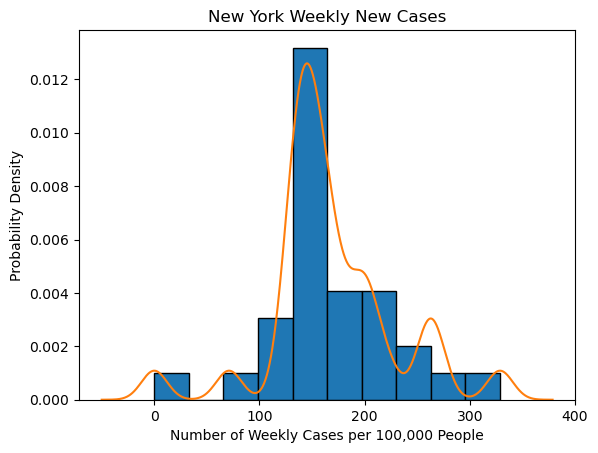

In [32]:
# create kde estimator
kde_ny = gaussian_kde(ny_normalized, bw_method = 0.2)

# evaluate pdf over kde domain
x_min = np.min(ny_normalized)
x_max = np.max(ny_normalized)
bound = 50
x_grid_ny = np.linspace(x_min - bound, x_max + bound, 1000)
pdf_ny = kde_ny(x_grid_ny)

# plot histogram and pdf
plt.hist(ny_normalized, 10, density = True, ec = 'black')
plt.plot(x_grid_ny, pdf_ny)
plt.xlabel('Number of Weekly Cases per 100,000 People')
plt.ylabel('Probability Density')
plt.title('New York Weekly New Cases')

# print statistics
print_kde_stats(kde_ny)

### D. New York KDE Analysis

This distribution looks far different than that of North Carolina's statistics.

Lets take a look at the mean and standard deviation. The mean is actually not too different; it's about 10 people less per 100,000 people than North Carolina. Of the two, the big difference is standard deviation.60.1 may not seem that different from 84.57, but that's almost a 50% increase. As a result, North Carolina has a far greater spread and variance than North Carolina, which we can see visually when comparing the two side by side.

The skewedness of the distribution demonstrates that this distribution is also slightly skewed, but this time, to the right instead of the left.

The kurtosis is also vastly different than North Carolina's distribution. While it is still platykurtic, it is much closer to a mesokurtic distribution (kurtosis = 3.0). So, the tail of this curve is longer in comparison.

Unlike North Carolina, this distribution has one massive peak along with one smaller, minor peak.

In [33]:
# drop non-FL rows
fl_df = base.drop(base[base['State'] != 'FL'].index)

# get FL population
fl_population = fl_df['population'].sum()

# get start and end indices
start_index = fl_df.columns.get_loc("cases 2022-06-01")
end_index = fl_df.columns.get_loc("cases 2022-12-31")

# calculate new cases
_, fl_cases_y = cumulate_weekly_data_columns(fl_df, start_index, end_index)
fl_normalized = normalize(fl_cases_y, fl_population, 100000)

Statistics per 100,000 People:
mean                              171.10
standard deviation                135.10
skewedness                          0.11
kurtosis                           -1.42


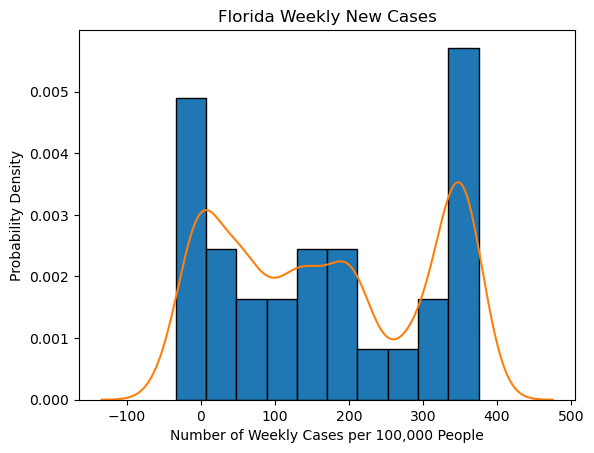

In [34]:
# create kde estimator
kde_fl = gaussian_kde(fl_normalized, bw_method = 0.2)

# evaluate pdf over kde domain
x_min = np.min(fl_normalized)
x_max = np.max(fl_normalized)
bound = 100
x_grid_fl = np.linspace(x_min - bound, x_max + bound, 1000)
pdf_fl = kde_fl(x_grid_fl)

# plot histogram and pdf
plt.hist(fl_normalized, 10, density = True, ec = 'black')
plt.plot(x_grid_fl, pdf_fl)
plt.xlabel('Number of Weekly Cases per 100,000 People')
plt.ylabel('Probability Density')
plt.title('Florida Weekly New Cases')

# print statistics
print_kde_stats(kde_fl)

### E. Florida KDE Analysis

In comparison to the other means, the mean of Florida's distribution is very similar; it's between North Carolina's and New York's mean.

It's standard deviation is significantly greater than either of the other two at 135.1, more than twice that of Florida's standard deviation. So, the spread is far greater in comparison.

Like New York, this distribution is slightly skewed to the right, although to a lesser degree.

Like the other two distributions, this is a platykurtic distribution; it has the least kurtosis out of the distributions so far, and it reflects graphically, too.

Visually, the curve looks more similar to North Carolina than it does to New York. Like North Carolina, it has two major peaks.

In [35]:
# drop non-KS rows
ks_df = base.drop(base[base['State'] != 'KS'].index)

# get KS population
ks_population = ks_df['population'].sum()

# get start and end indices
start_index = ks_df.columns.get_loc("cases 2022-06-01")
end_index = ks_df.columns.get_loc("cases 2022-12-31")

# calculate new cases
_, ks_cases_y = cumulate_weekly_data_columns(ks_df, start_index, end_index)
ks_normalized = normalize(ks_cases_y, ks_population, 100000)

Statistics per 100,000 People:
mean                              146.60
standard deviation                 64.69
skewedness                          0.02
kurtosis                           -0.60


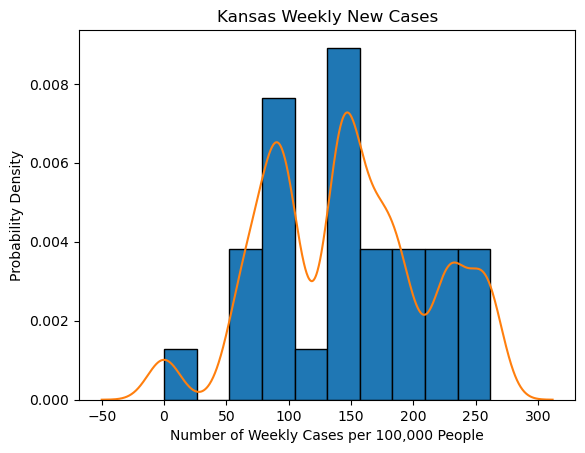

In [36]:
# create kse estimator
kse_ks = gaussian_kde(ks_normalized, bw_method = 0.2)

# evaluate pdf over kse domain
x_min = np.min(ks_normalized)
x_max = np.max(ks_normalized)
bound = 50
x_grid_ks = np.linspace(x_min - bound, x_max + bound, 1000)
pdf_ks = kse_ks(x_grid_ks)

# plot histogram and pdf
plt.hist(ks_normalized, 10, density = True, ec = 'black')
plt.plot(x_grid_ks, pdf_ks)
plt.xlabel('Number of Weekly Cases per 100,000 People')
plt.ylabel('Probability Density')
plt.title('Kansas Weekly New Cases')

# print statistics
print_kde_stats(kse_ks)

### F. Kansas KDE Analysis

The distribution for Kansas is similar to both North Carolina and New York.

Out of all the distributions, it has the lowest mean. It has a similar standard deviation in comparison to New York. Out of all the distributions, it has the least skewedness. In fact, it's so low (0.02) that I would go so far as to say that it's practically negligible. It's kurtosis is similar to North Carolina.

The shape of the curve is weird. It's so close to converging on a single peak, but instead, it has two peaks that are very close to each other.

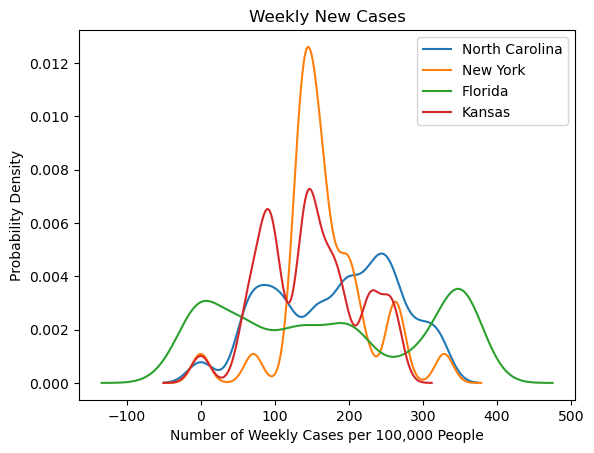

In [37]:
plt.plot(x_grid_nc, pdf_nc, label = 'North Carolina')
plt.plot(x_grid_ny, pdf_ny, label = 'New York')
plt.plot(x_grid_fl, pdf_fl, label = 'Florida')
plt.plot(x_grid_ks, pdf_ks, label = 'Kansas')

plt.xlabel('Number of Weekly Cases per 100,000 People')
plt.ylabel('Probability Density')
plt.title('Weekly New Cases')
plt.legend()

### G. All KDEs

Before moving onto section II, I wanted to put all the kdes I've built into one graph to show them all together.

There isn't much I want to comment on that I haven't already stated in previous subsections. One thing I noticed now that I didn't before is that the peaks, even the minor ones, but especially major ones, tend to coincide with the peak of at least one other state, sometimes several other states. Despite the vastly different spreads, the distributions still share some characteristics.

## Section II: Correlation Calculations

### A. Section Overview

In this section, I'll calculate correlation between new cases and enrichment variables. Before I can do so, I need to decide upon a few things regarding the methodology. 

First, do I want to compare state data or county data? Ultimately, the choice affects whether I'll be analyzing from a holistic view, or inspecting one specific state in order to learn more about how that state was impacted by Covid. I gave it some thought, and I decided I want to compare different states to each other, so that means aggregating state covid cases and collecting state employment data.

There is another decision to make, and that is over what time span do I want to analyze? Part of the issue is, so far, I have been working with data from only the second half of 2022 for this project, but that is no longer an option due to what is covered by the enrichment dataset. Unfortunately, quarter four of 2022 data has not been released yet, so the most recent data I have access to is quarter three of 2022. There is also the issue that the employment dataset, both the base and the merged datasets, are for the year 2021 as a whole.

Finally, there is the issue that, in the merged dataset, I dropped the rows containing statewide information.

So, the more I think about it, the more apparent it becomes that I need to revisit the problem of datasets: what datasets do I want to use, and how do I want to merge them? Due to how the datasets are released, it makes sense to do either a single quarter, or an entire year. 

Once again, I've given the problem some thought, and I have decided that I will perform analysis between quarter three of 2022 new cases to employment data nationwide. This has both upsides and downsides. The upside is that the data is as recent as possible, so its patterns will hopefully be more relevant. The downside is by limiting the data to a single quarter, there are few datapoints to work with when calculating the mean new cases of a single state.

So now that I have covered the specific details, I have clear steps in mind that I need to take in order to accomplish the task. They are outlined below:
1. Download the quarter three employment dataset.
2. For all fifty states, calculate the mean number of new cases between 7/1/22 and 9/30/22.
3. For all fifty states, access the statewide, all industries row and grab the enrichment variables I want to correlate to cases.
4. Perform the correlation calculation and plot the data.

This time, I will not be performing merges. I don't think they are necessary, so I will not. Like previously, I will be calculating weekly data since the infrastructure to do so has already been implemented. 

As for the enrichment variables I want to correlate, I will begin with establishment count, employment, and average weekly wages. Average weekly wages does not need to be normalized; it's independent of population. However, establishment count will need to be normalized, and so will employment. For employment, it makes sense to represent that as a percentage of the population that is employed. Since this is quarterly data, this information is stored on a per month basis, so I will need to average that data together. For establishment count, this can be normalized similarly to new cases data.

That covers the details of the overview. There's nothing left to talk about, so I will begin the process.

In [45]:
# read enrichment dataset
employment_data = pd.read_excel('../Data/q3_22_employment.xlsx')

# create dictionary for storing state names and abbreviations.
# I did not write this; the dictionary comes from the following source:
# https://gist.github.com/rogerallen/1583593
# It has been edited to only contain states and not territories

us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY"
#     "District of Columbia": "DC",
#     "American Samoa": "AS",
#     "Guam": "GU",
#     "Northern Mariana Islands": "MP",
#     "Puerto Rico": "PR",
#     "United States Minor Outlying Islands": "UM",
#     "U.S. Virgin Islands": "VI",
}

# The following district will contain information for each state:
# cases, population, average weekly wages, establishment count, and employment

states_data = {}

In [46]:
nf = 100000

# populate states data
for key, value in us_state_to_abbrev.items():
    # drop non-NC rows
    state_df = base.drop(base[base['State'] != value].index)

    # store NC population
    states_data[key] = {}
    states_data[key]['population'] = state_df['population'].sum()

    # get start and end indices
    start_index = state_df.columns.get_loc("cases 2022-07-01")
    end_index = state_df.columns.get_loc("cases 2022-09-30")

    # calculate new cases
    _, new_cases = cumulate_weekly_data_columns(state_df, start_index, end_index)   
    cases_normalized = normalize(new_cases, states_data[key]['population'], nf)
    
    # store mean of new cases
    states_data[key]['cases'] = np.mean(cases_normalized)
    
    # get the row for the current state
    state_employment_data = employment_data[(employment_data['Area Type'] == 'State') & 
                                      (employment_data['St Name'] == key) &
                                      (employment_data['Ownership'] == 'Total Covered')]
    
    # get and store establishment count
    establishment = state_employment_data['Establishment Count'].iloc[0]
    establishment_normalized = establishment / states_data[key]['population'] * nf
    states_data[key]['establishment_count'] = establishment_normalized
    
    # get and store employment as a percentage
    employment_july = establishment = state_employment_data['July Employment'].iloc[0]
    employment_august = establishment = state_employment_data['August Employment'].iloc[0]
    employment_september = establishment = state_employment_data['September Employment'].iloc[0]
    employment_avg = np.mean([employment_july, employment_august, employment_september])
    employment_percentage = employment_avg / states_data[key]['population']
    states_data[key]['employment'] = employment_percentage
    
    # get and store average weekly wage
    avg_weekly_wage = establishment = state_employment_data['Average Weekly Wage'].iloc[0]
    states_data[key]['avg_weekly_wage'] = avg_weekly_wage

### B. Calculating Correlation

By this point, the state data is now stored in the states_data dictionary. Due to how I stored it, however, I will need to loop through the dictionary and create lists of all the attributes for each state. From there I can perform the correlations and plot the data.

In [40]:
cases_data = []
establishment_data = []
employment_data = []
weekly_wage_data = []

# populate lists of data
for key in states_data:
    cases_data.append(states_data[key]['cases'])
    establishment_data.append(states_data[key]['establishment_count'])
    employment_data.append(states_data[key]['employment'])
    weekly_wage_data.append(states_data[key]['avg_weekly_wage'])
    
# calculate correlations
establishment_correlation = np.corrcoef(cases_data, establishment_data)[0, 1]
employment_correlation = np.corrcoef(cases_data, employment_data)[0, 1]
weekly_wage_correlation = np.corrcoef(cases_data, weekly_wage_data)[0, 1]

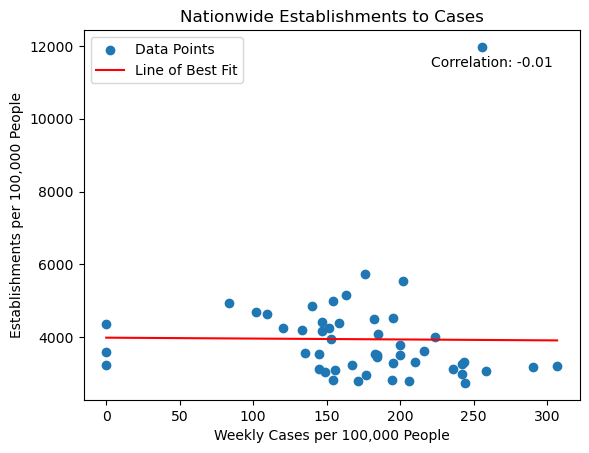

In [41]:
# calculate line of best fit
coefficients = np.polyfit(cases_data, establishment_data, 1)
x_line = np.linspace(min(cases_data), max(cases_data), 100)
y_line = np.polyval(coefficients, x_line)

# plot data for establishment correlation
plt.scatter(cases_data, establishment_data, label = 'Data Points')
plt.xlabel('Weekly Cases per 100,000 People')
plt.ylabel('Establishments per 100,000 People')
plt.title('Nationwide Establishments to Cases')
plt.plot(x_line, y_line, color = 'red', label = 'Line of Best Fit')
plt.legend()
plt.annotate(f'Correlation: {establishment_correlation:.2f}', xy = (0.7, 0.9), xycoords = 'axes fraction')
plt.show()

### C. Establishment Correlation Analysis

Just by looking at the graph, there doesn't appear to be a correlation, or if there is, it's very negligible. The correlation value of -0.01 backs this up. Correlation values of 0 are supposed to indicate that the variables are entirely unrelated, so it's likely that cases are not correlated to establishment count.

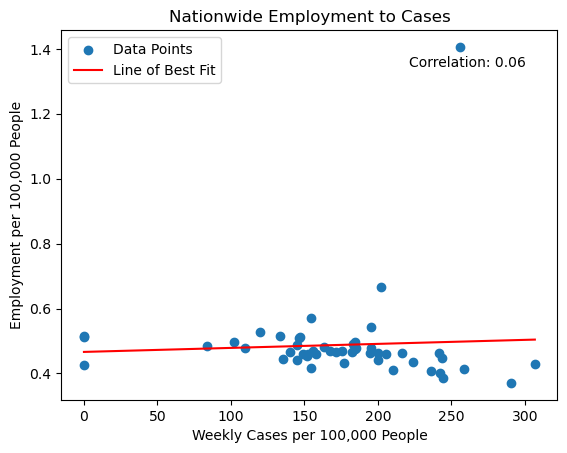

In [42]:
# calculate line of best fit
coefficients = np.polyfit(cases_data, employment_data, 1)
x_line = np.linspace(min(cases_data), max(cases_data), 100)
y_line = np.polyval(coefficients, x_line)

# plot data for employment correlation
plt.scatter(cases_data, employment_data, label = 'Data Points')
plt.xlabel('Weekly Cases per 100,000 People')
plt.ylabel('Employment per 100,000 People')
plt.title('Nationwide Employment to Cases')
plt.plot(x_line, y_line, color = 'red', label = 'Line of Best Fit')
plt.legend()
plt.annotate(f'Correlation: {employment_correlation:.2f}', xy = (0.7, 0.9), xycoords = 'axes fraction')
plt.show()

### D. Employment Cases Analysis

Once again, there does not appear to be a strong correlation here. Unlike the previous correlation, this one is slightly positive and stronger than the correlation for establishments. Overall, it's unlikely that cases are correlated to employment.

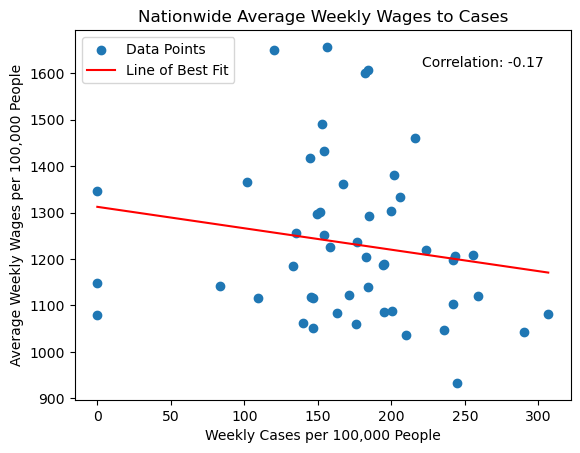

In [43]:
# calculate line of best fit
coefficients = np.polyfit(cases_data, weekly_wage_data, 1)
x_line = np.linspace(min(cases_data), max(cases_data), 100)
y_line = np.polyval(coefficients, x_line)

# plot data for weekly_wage correlation
plt.scatter(cases_data, weekly_wage_data, label = 'Data Points')
plt.xlabel('Weekly Cases per 100,000 People')
plt.ylabel('Average Weekly Wages per 100,000 People')
plt.title('Nationwide Average Weekly Wages to Cases')
plt.plot(x_line, y_line, color = 'red', label = 'Line of Best Fit')
plt.annotate(f'Correlation: {weekly_wage_correlation:.2f}', xy = (0.7, 0.9), xycoords = 'axes fraction')
plt.legend(loc = 'upper left')
plt.show()

### E. Average Weekly Wages Correlation Analysis

Out of the variables I have analyzed so far, average weekly wages seems the most likely to be correlated to weekly cases of covid. However, the correlation is still rather weak. More analysis would be needed to confirm whether there is a relationship or if the corrleation is a fluke. One thing to note is that the data appears far more scattered than the other two graphs, but this might simply due to the range that has been chosen.

## Section III: Hypotheses

I propose the following hypotheses below based on the variables that I chose for the previous section. Looking at the data, it is unlikely that any of the variables I analyzed in the previous section are correlated with the exception fo cases and average weekly wages. Still, it is perhaps worth confirming this through hypothesis testing.
- Does an increase in covid cases affect average weekly wages?
- Does an increase in covid cases affect employment?
- Does an increase in covid cases affect the number of establishments?